# Cancer patient quality-of-life (QOL) multivariate regression modeling using neural networks
Notebook by Aditya Tapshalkar

Kaggle dataset: https://www.kaggle.com/datasets/zahidmughal2343/global-cancer-patients-2015-2024
___

## Abstract
Cancer patients often experience reduced quality of life (QoL) due to factors including physical, mental, and emotional well-being; social status; and financial security.
This case study explores a method of estimating key indicators of quality of life (QoL) in cancer patients around the world.

## Introduction
Quality of life (QoL) is a subjective metric that measures an individual's overall satisfaction with their well-being and their surroundings. Some contributors to QoL include (but are not limited to) physical, mental, and spiritual well-being, interpersonal relationships, social status, and financial security (Teoli and Bhardwaj).

Cancer, characterized as abnormal cell growth in the body, is a leading cause of death globally. Depending on the cancer diagnosis, treatment costs are often steep in many countries, which can burden patients' and their families financially. Cancer symptoms - such as pain, insomnia, fatigue - can deteriorate mental and physical health, further exacerbating patient QoL. Cancer patients with lower perceived QoL commonly suffer from Cancer-Related Fatigue (CRF) which is defined as declining psychological well-being due to depression, guilt, and lack of understanding of their difficulties, which can lead to detachment and inadequacy in their family and social circles (Caldiroli et al.). One study by Nayak et al. found 82.3% of sampled cancer patients to self-report a below-average QoL, with many citing general well-being, socioeconomic circumstances, and cancer symptoms as justification for lower perceived QoL.

Hospice and palliative care aims to maximize patients' QoL during serious or terminal illness including cancer. QoL can be gauged during palliative or hospice care through means such as providing questionnaires to patients. However, these questionnaires are often specific to the hospice/palliative care and do not incorporate factors beyond patient well-being, such as treatment costs, country of care, and socioeconomic situation. Because of this, holistic QoL is difficult to gauge in cancer patients without knowledge of these external factors.

## Problem definition
Can a model be trained to predict QoL in cancer patients using data across multiple different aspects of QoL?

### Dataset selection
For this project, the `global_cancer_patients_2015_2024` dataset, [published by Zahid Feroze](https://www.kaggle.com/datasets/zahidmughal2343/global-cancer-patients-2015-2024/data), will be used.

This dataset includes 50,000 unique and anonymized values from cancer patients globally from 2015 to 2024. This dataset has 15 columns including patients' medical history, cancer and treatment details, and general demographics.

In [1]:
%env KAGGLEHUB_CACHE=/mnt/devbox/kaggle

# Importing libraries
import copy
import os
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from skorch import NeuralNetRegressor
from skorch.helper import to_numpy
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics import R2Score

torch.manual_seed(99)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch version:", torch.__version__)
print('Device:', device)

env: KAGGLEHUB_CACHE=/mnt/devbox/kaggle
PyTorch version: 2.5.1
Device: cuda


In [2]:
path = kagglehub.dataset_download("zahidmughal2343/global-cancer-patients-2015-2024")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "global_cancer_patients_2015_2024.csv"))
df.head()

Path to dataset files: /mnt/devbox/kaggle/datasets/zahidmughal2343/global-cancer-patients-2015-2024/versions/1


,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62


### Model objective
Because QoL is not an objective metric, there is no clear-cut standardized calculation for QoL. In the context of this project and the selected dataset, QoL will be broken down across three specific columns from the dataset:
- Treatment cost (financial responsibility): `Treatment_Cost_USD`
  - Higher treatment costs correlate with higher financial burden on patients and families, which can reduce patient QoL
- Survival years after diagnosis (physical wellbeing): `Survival_Years`
  - Fewer years of survival post-diagnosis could indicate patients succumbing to disease earlier
- Severity score (symptom management): `Target_Severity_Score`
  - Higher severity score could indicate the relative intensity of symptoms, which can lead to lower QoL estimates

To predict regression values for all three outputs, the model strategy will be multivariate regression.

## Exploratory Data Analysis (EDA)

In [3]:
# Looking at the first few rows
df.head(10)

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
0,PT0000000,71,Male,UK,2021,6.4,2.8,9.5,0.9,8.7,Lung,Stage III,62913.44,5.9,4.92
1,PT0000001,34,Male,China,2021,1.3,4.5,3.7,3.9,6.3,Leukemia,Stage 0,12573.41,4.7,4.65
2,PT0000002,80,Male,Pakistan,2023,7.4,7.9,2.4,4.7,0.1,Breast,Stage II,6984.33,7.1,5.84
3,PT0000003,40,Male,UK,2015,1.7,2.9,4.8,3.5,2.7,Colon,Stage I,67446.25,1.6,3.12
4,PT0000004,43,Female,Brazil,2017,5.1,2.8,2.3,6.7,0.5,Skin,Stage III,77977.12,2.9,3.62
5,PT0000005,22,Male,Germany,2018,9.5,6.4,3.3,3.9,5.1,Cervical,Stage IV,33468.99,9.5,5.98
6,PT0000006,41,Male,Canada,2021,5.1,8.2,0.3,3.7,2.1,Cervical,Stage 0,9790.83,1.0,5.05
7,PT0000007,72,Female,Canada,2018,6.0,8.2,6.4,0.6,8.5,Prostate,Stage I,17161.40,6.2,6.02
8,PT0000008,21,Male,USA,2022,4.3,3.8,1.0,0.3,8.5,Lung,Stage II,56458.48,6.5,3.36
9,PT0000009,49,Female,Canada,2016,8.1,0.8,7.8,5.2,9.3,Prostate,Stage II,56133.45,5.7,5.76


In [4]:
# Checking for missing values
df.loc[df.isnull().any(axis=1)]

,Patient_ID,Age,Gender,Country_Region,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Type,Cancer_Stage,Treatment_Cost_USD,Survival_Years,Target_Severity_Score


Great - no rows with missing values. No need for data interpolation.

In [5]:
# Dataset distribution
print(df.nunique())
df.describe()

Patient_ID               50000
Age                         70
Gender                       3
Country_Region              10
Year                        10
Genetic_Risk               101
Air_Pollution              101
Alcohol_Use                101
Smoking                    101
Obesity_Level              101
Cancer_Type                  8
Cancer_Stage                 5
Treatment_Cost_USD       49861
Survival_Years             101
Target_Severity_Score      744
dtype: int64


,Age,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Treatment_Cost_USD,Survival_Years,Target_Severity_Score
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,54.421540,2019.480520,5.001698,5.010126,5.010880,4.989826,4.991176,52467.298239,5.006462,4.951207
std,20.224451,2.871485,2.885773,2.888399,2.888769,2.881579,2.894504,27363.229379,2.883335,1.199677
min,20.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5000.050000,0.000000,0.900000
25%,37.000000,2017.000000,2.500000,2.500000,2.500000,2.500000,2.500000,28686.225000,2.500000,4.120000
50%,54.000000,2019.000000,5.000000,5.000000,5.000000,5.000000,5.000000,52474.310000,5.000000,4.950000
75%,72.000000,2022.000000,7.500000,7.500000,7.500000,7.500000,7.500000,76232.720000,7.500000,5.780000
max,89.000000,2024.000000,10.000000,10.000000,10.000000,10.000000,10.000000,99999.840000,10.000000,9.160000


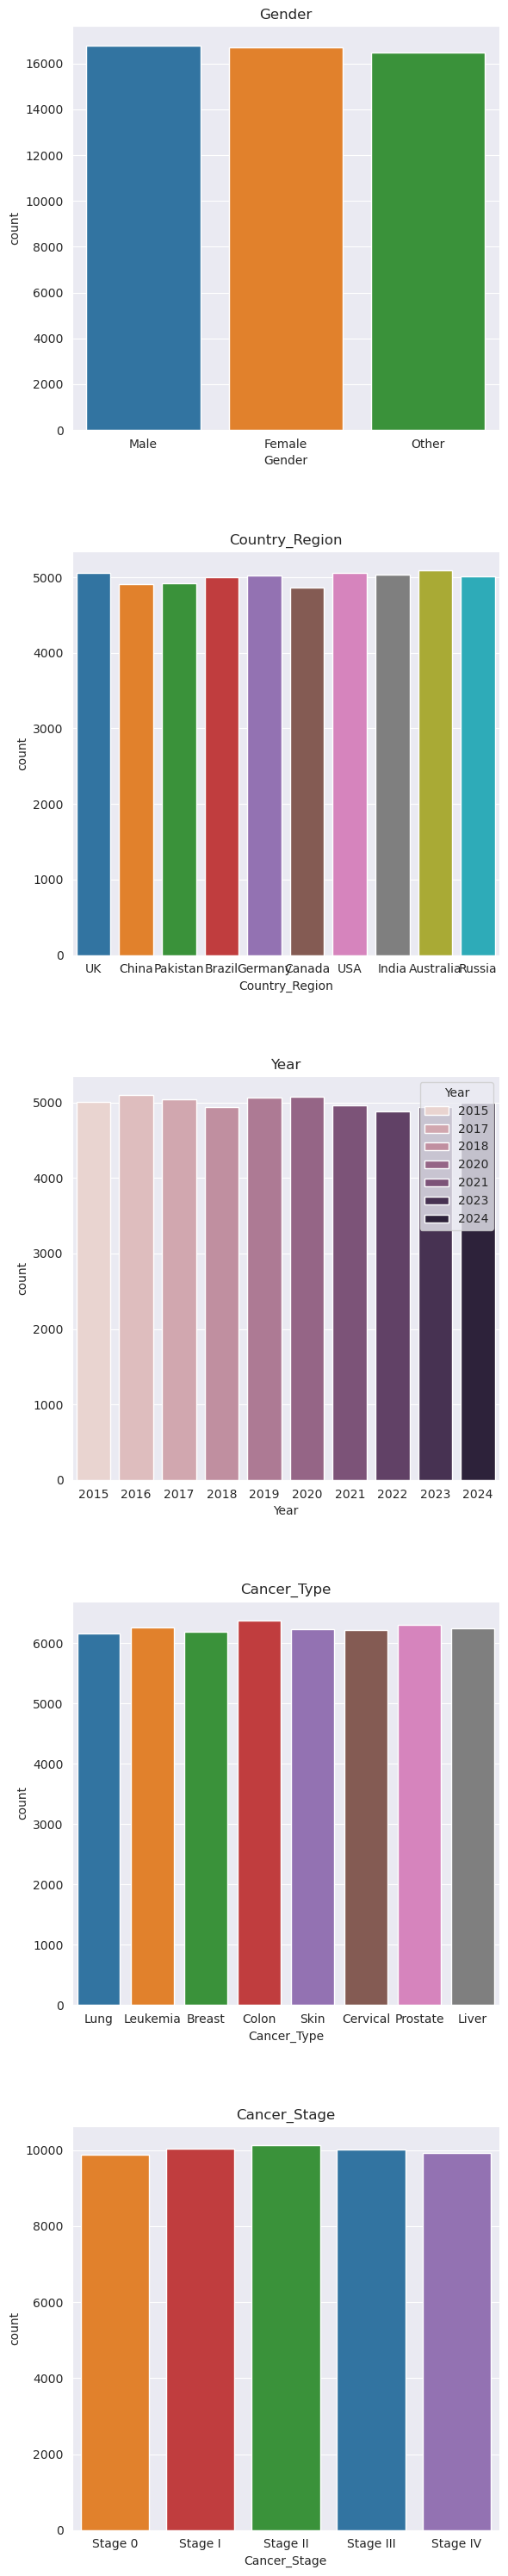

In [6]:
# Plotting categorical data
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6, 30))

sns.countplot(df, x="Gender", hue="Gender", ax=axes[0])
axes[0].set_title("Gender")

sns.countplot(df, x="Country_Region", hue="Country_Region", ax=axes[1])
axes[1].set_title("Country_Region")

sns.countplot(df, x="Year", hue="Year", ax=axes[2])
axes[2].set_title("Year")

sns.countplot(df, x="Cancer_Type", hue="Cancer_Type", ax=axes[3])
axes[3].set_title("Cancer_Type")

sns.countplot(df, x="Cancer_Stage", hue="Cancer_Stage",
              order=["Stage 0", "Stage I", "Stage II", "Stage III", "Stage IV"],
              ax=axes[4])
axes[4].set_title("Cancer_Stage")

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

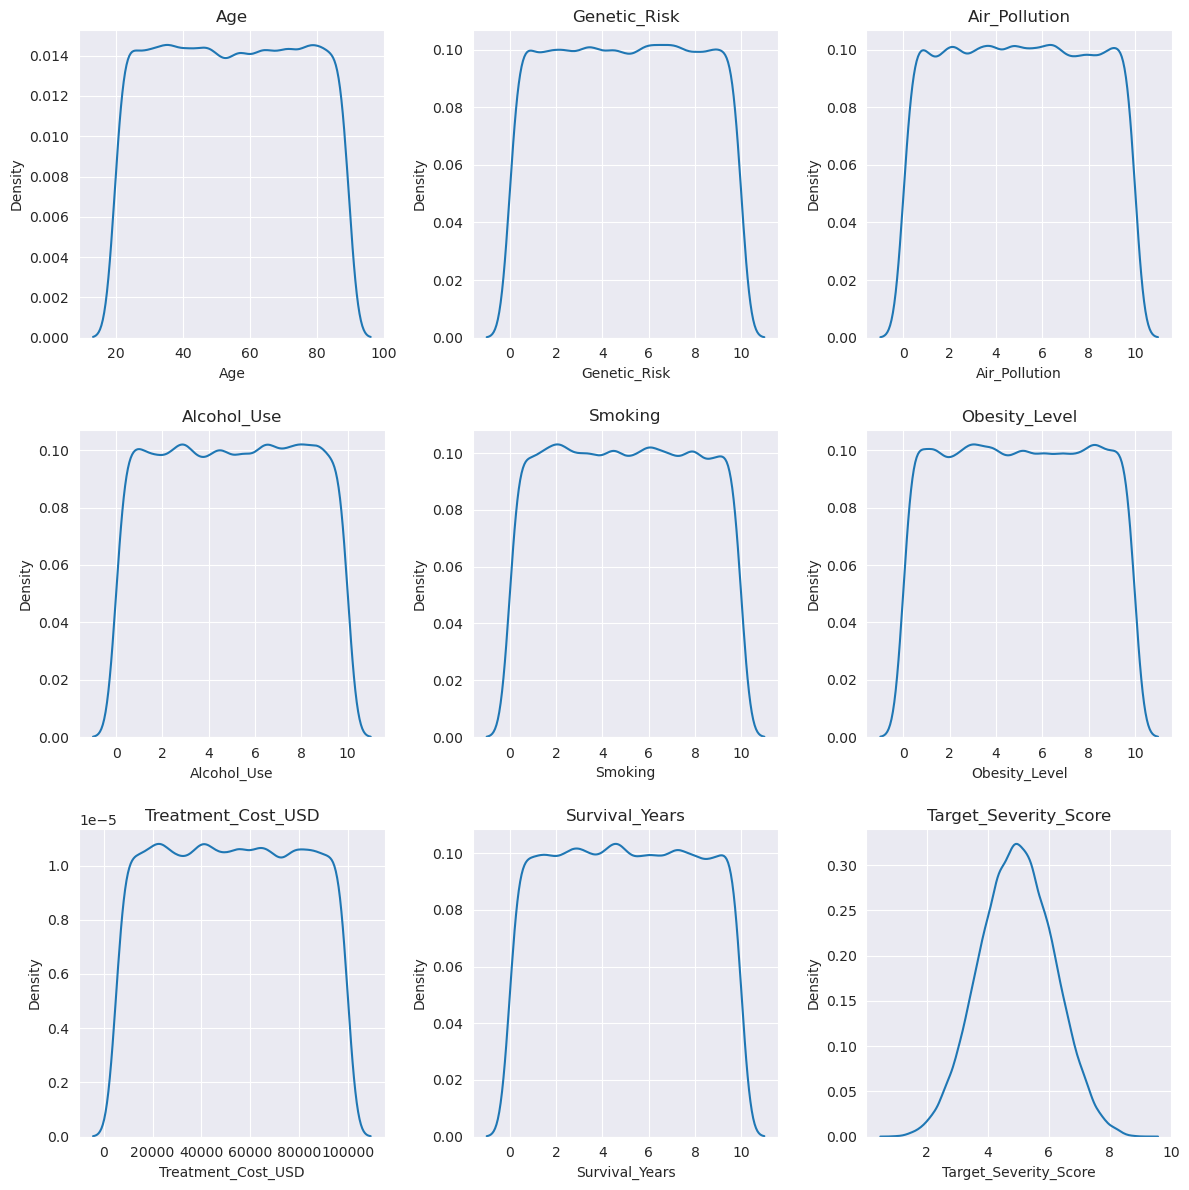

In [7]:
# Plotting continuous data
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))  # 9 columns

sns.kdeplot(df, x="Age", ax=axes[0][0])
axes[0][0].set_title("Age")

sns.kdeplot(df, x="Genetic_Risk", ax=axes[0][1])
axes[0][1].set_title("Genetic_Risk")

sns.kdeplot(df, x="Air_Pollution", ax=axes[0][2])
axes[0][2].set_title("Air_Pollution")

sns.kdeplot(df, x="Alcohol_Use", ax=axes[1][0])
axes[1][0].set_title("Alcohol_Use")

sns.kdeplot(df, x="Smoking", ax=axes[1][1])
axes[1][1].set_title("Smoking")

sns.kdeplot(df, x="Obesity_Level", ax=axes[1][2])
axes[1][2].set_title("Obesity_Level")

sns.kdeplot(df, x="Treatment_Cost_USD", ax=axes[2][0])
axes[2][0].set_title("Treatment_Cost_USD")

sns.kdeplot(df, x="Survival_Years", ax=axes[2][1])
axes[2][1].set_title("Survival_Years")

sns.kdeplot(df, x="Target_Severity_Score", ax=axes[2][2])
axes[2][2].set_title("Target_Severity_Score")

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

### Initial observations of categorical features
- This dataset is (surprisingly) relatively balanced in all categories. This will minimize the need to perform any resampling, especially since we have a large sample size. (\$m=50000\$)
- One-hot encoding can be used to represent each of these categorical features.

### Initial observations of continuous features
- All continuous features, except for `Target_Severity_Score`, seem to follow a uniform data distribution. `Target_Severity_Score` follows a normal (Gaussian) distribution.
    - The `Target_Severity_Score` feature could benefit from standardization, and other continuous features could benefit from normalization.

### Correlation matrix
The Pearson correlation coefficient was used to display the linear correlation between any two features in the dataset. The formula for the Pearson correlation coefficient (\$\rho\$) for any two datasets (or features) \$n_1\$ and \$n_2\$ is:

$$
\rho_{n_1,n_2} = \frac{\text{cov}(n_1,n_2)}{\sigma_{n_1}\sigma_{n_2}}
$$

Where \$\text{cov}(n_1,n_2)\$ represents the covariance between \$n_1\$ and \$n_2\$, and \$\sigma_{n_x}\$ and \$\sigma_{n_y}\$ represent the standard deviations of \$n_1\$ and \$n_2\$, respectively.

<Axes: >

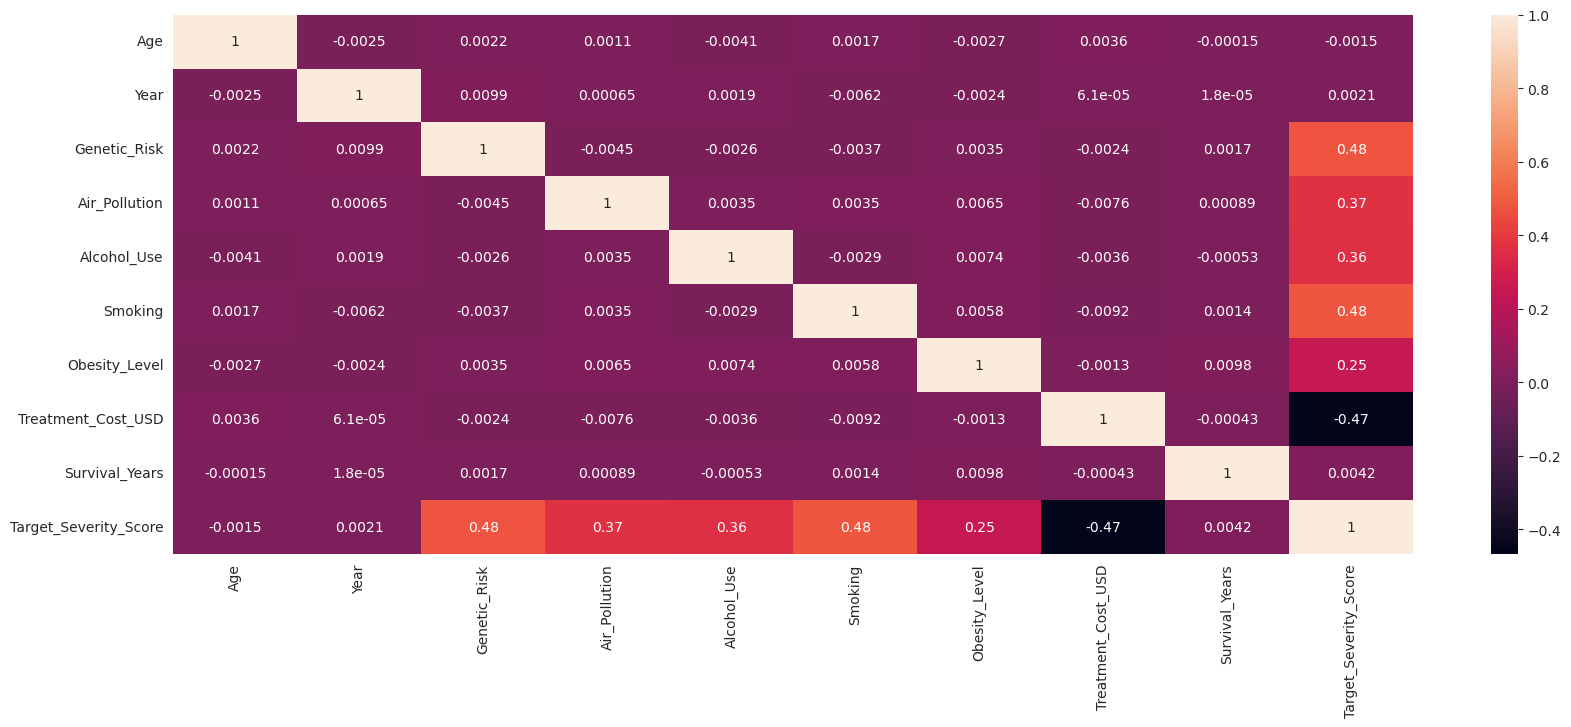

In [8]:
# Numerical feature correlation matrix
fig, axes = plt.subplots(figsize=(20, 7))
sns.heatmap(df.corr('pearson', numeric_only=True), annot=True, ax=axes)

### Numerical feature correlation observations
- There is a relatively strong correlation between patients' diet, smoking, and drinking history and their cancer severity score.
    - There is a relatively strong positive correlation between `Target_Severity_Score` and `Smoking` (0.48).
    - There is a moderately positive correlation between `Target_Severity_Score` and `Alcohol_Use` (0.36). `Obesity_Level` also positively correlates with `Target_Severity_Score` at a lesser degree (0.25).
- Other features like `Genetic_Risk` and `Air_Pollution` also positively correlate with `Target_Severity_Score`.
- Interestingly, `Treatment_Cost_USD` strongly negatively correlates with `Target_Severity_Score` (-0.47). This could indicate that patients who experience more intense symptoms of their cancers opt for palliative or hospice care, which may be significantly less expensive than active treatment with radiation and chemotherapy.

## Feature engineering and data preprocessing
For multivariate regression modeling with neural networks, we will need to prepare the features for training.

### Categorical features
- Our input features include both numerical and categorical data, so we could employ one-hot encoding for category-type features.
    - The benefit of using one-hot encoding is to allow the network to learn categorical representation of features orthogonally. The downside to one-hot encoding is that as the number of categories go up in a feature, the number of extra features are added to the input.

Here's an example of a categorical feature across multiple samples:

| | Sample 1 | Sample 2 | Sample 3 | Sample 4 | Sample 5 |
| --- | --- | --- | --- | --- | --- |
| ... | | | | | |
| `Cancer_Type` | "Lung" | "Skin" | "Colon" | "Cervical" | "Skin" |
| ... | | | | | |

With one-hot encoding, we can "explode" this feature into multiple binary features:

| | Sample 1 | Sample 2 | Sample 3 | Sample 4 | Sample 5 |
| --- | -- | --- | --- | --- | --- |
| ... | | | | | |
| `Cancer_Type_Lung` | 1 | 0 | 0 | 0 | 0 |
| `Cancer_Type_Skin` | 0 | 1 | 0 | 0 | 1 |
| `Cancer_Type_Colon` | 0 | 0 | 1 | 0 | 0 |
| `Cancer_Type_Cervical` | 0 | 0 | 0 | 1 | 0 |
| ... | | | | | |

<br/>

Note: `Cancer_Stage` in this dataset is categorical; however, we could represent `Cancer_Stage` as a numerical feature, as each category represents a stage in the cancer prognosis.


In [9]:
# Example of one-hot encoding of `Cancer_Type` feature
# Note: during actual feature pre-processing, we will use sklearn.preprocessing.OneHotEncoder().
pd.get_dummies(df.sample(5)[['Cancer_Type']], dtype=int)

,Cancer_Type_Colon,Cancer_Type_Liver,Cancer_Type_Skin
41037,1,0,0
34336,1,0,0
32997,1,0,0
49608,0,0,1
14929,0,1,0


### Numerical features
- `Genetic_Risk`, `Air_Pollution`, `Alcohol_Use`, `Smoking`, and `Obesity_Level` are medical history data points and use the same scale (0-10). `Target_Severity_Score` also resides on the same scale (0-10). For these features that reside on a min-max scale, normalization may work better, where scale values between 0 and 10 become scaled between values between 0 and 1.
- `Survival_Years` values also reside between 0-10, but for features not on a definitive scale (including `Treatment_Cost_USD`, `Age`, etc.), standardization may work better.
- For output features `Target_Severity_Score`, `Treatment_Cost_USD`, and `Survival_Years`, it is imperative to denormalize/de-standardize features to produce actual output values relevant to the output feature representations.
    - For example, standardized `Treatment_Cost_USD` values, where \$\mu=0\$ and \$\sigma=1\$, will need to be converted back into USD representations of the estimated treatment cost.

The normalization formula for a feature set \$X\$ can be written as:

$$
X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}
$$

The standardization formula for a feature set \$X\$ can be written as:

$$
X_{standardized} = \frac{X - \mu_{X}}{\sigma_{X}}
$$

In [10]:
# Example of normalization (between 0 and 1)
# Note: during actual feature preprocessing, we will use sklearn.preprocessing.MinMaxScaler().
norm_example = df.sample(5)[['Treatment_Cost_USD']]
norm_example = (norm_example - norm_example.min()) / (norm_example.max() - norm_example.min())
norm_example

,Treatment_Cost_USD
14972,0.844753
16483,0.383066
49985,0.959922
14366,1.000000
12484,0.000000


In [11]:
# Example of standardization (mean = 0, standard deviation = 1)
# Note: during actual feature preprocessing, we will use sklearn.preprocessing.StandardScaler().
standardize_example = df.sample(5)[['Target_Severity_Score']]
standardize_example = (standardize_example - standardize_example.mean()) / standardize_example.std()
standardize_example

,Target_Severity_Score
34846,-0.556206
42800,1.588917
27523,-0.310322
1715,-0.997101
30478,0.274711


### Feature engineering proposal:
#### Input features
- `Patient_ID`: can be omitted from training
- `Age`: unbounded continuous feature; can be standardized (could also be categorical)
- `Gender`: one-hot encoded categorical feature
- `Year`: unbounded continuous feature; can be standardized
- `Country_Region`: one-hot encoded categorical feature
- `Genetic_Risk`, `Air_Pollution`, `Alcohol_Use`, `Smoking`, `Obesity_Level`: scaled continuous feature between 0-10; can be normalized
- `Cancer_Type`: one-hot encoded categorical feature
- `Cancer_Stage`: categorical feature, should be transformed into numerical feature, can be normalized

#### Output features
- `Treatment_Cost_USD`: unbounded continuous feature; should be standardized (helps with balanced learning between output feature scales)
- `Survival_Years`: unbounded continuous feature; should be standardized
- `Target_Severity_Score` bounded continuous feature (0-10):

> Note: feature scaling should only be applied after splitting training, validation, and test sets. It is important to only `fit_transform` the training set, and `transform` the validation and test sets to prevent data leakage.

In [12]:
# Define transformer for transforming `Cancer_Stage` into numerical feature:
cancer_stage_dict = {
    'Stage 0': 0,    # carcinoma in situ
    'Stage I': 1,
    'Stage II': 2,
    'Stage III': 3,
    'Stage IV': 4,
}

def cancer_stage_map(cancer_stage_col):
    return cancer_stage_col.map(cancer_stage_dict.get)

In [13]:
df_engineered = df.copy().drop('Patient_ID', axis=1)
df_engineered['Cancer_Stage'] = df_engineered['Cancer_Stage'].apply(cancer_stage_dict.get)
df_engineered = pd.get_dummies(df_engineered)
df_engineered

,Age,Year,Genetic_Risk,Air_Pollution,Alcohol_Use,Smoking,Obesity_Level,Cancer_Stage,Treatment_Cost_USD,Survival_Years,...,Country_Region_UK,Country_Region_USA,Cancer_Type_Breast,Cancer_Type_Cervical,Cancer_Type_Colon,Cancer_Type_Leukemia,Cancer_Type_Liver,Cancer_Type_Lung,Cancer_Type_Prostate,Cancer_Type_Skin
0,71,2021,6.4,2.8,9.5,0.9,8.7,3,62913.44,5.9,...,True,False,False,False,False,False,False,True,False,False
1,34,2021,1.3,4.5,3.7,3.9,6.3,0,12573.41,4.7,...,False,False,False,False,False,True,False,False,False,False
2,80,2023,7.4,7.9,2.4,4.7,0.1,2,6984.33,7.1,...,False,False,True,False,False,False,False,False,False,False
3,40,2015,1.7,2.9,4.8,3.5,2.7,1,67446.25,1.6,...,True,False,False,False,True,False,False,False,False,False
4,43,2017,5.1,2.8,2.3,6.7,0.5,3,77977.12,2.9,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,80,2023,2.3,7.5,2.8,3.8,2.9,0,71463.70,1.0,...,False,False,False,False,False,True,False,False,False,False
49996,40,2018,6.4,3.5,2.9,9.0,9.8,1,49619.66,0.4,...,False,True,False,False,True,False,False,False,False,False
49997,74,2015,6.2,1.6,8.7,4.7,4.0,0,5338.25,2.7,...,False,False,True,False,False,False,False,False,False,False
49998,21,2018,4.0,6.5,7.6,8.6,8.1,4,45100.47,7.5,...,False,False,False,False,False,False,True,False,False,False


<Axes: >

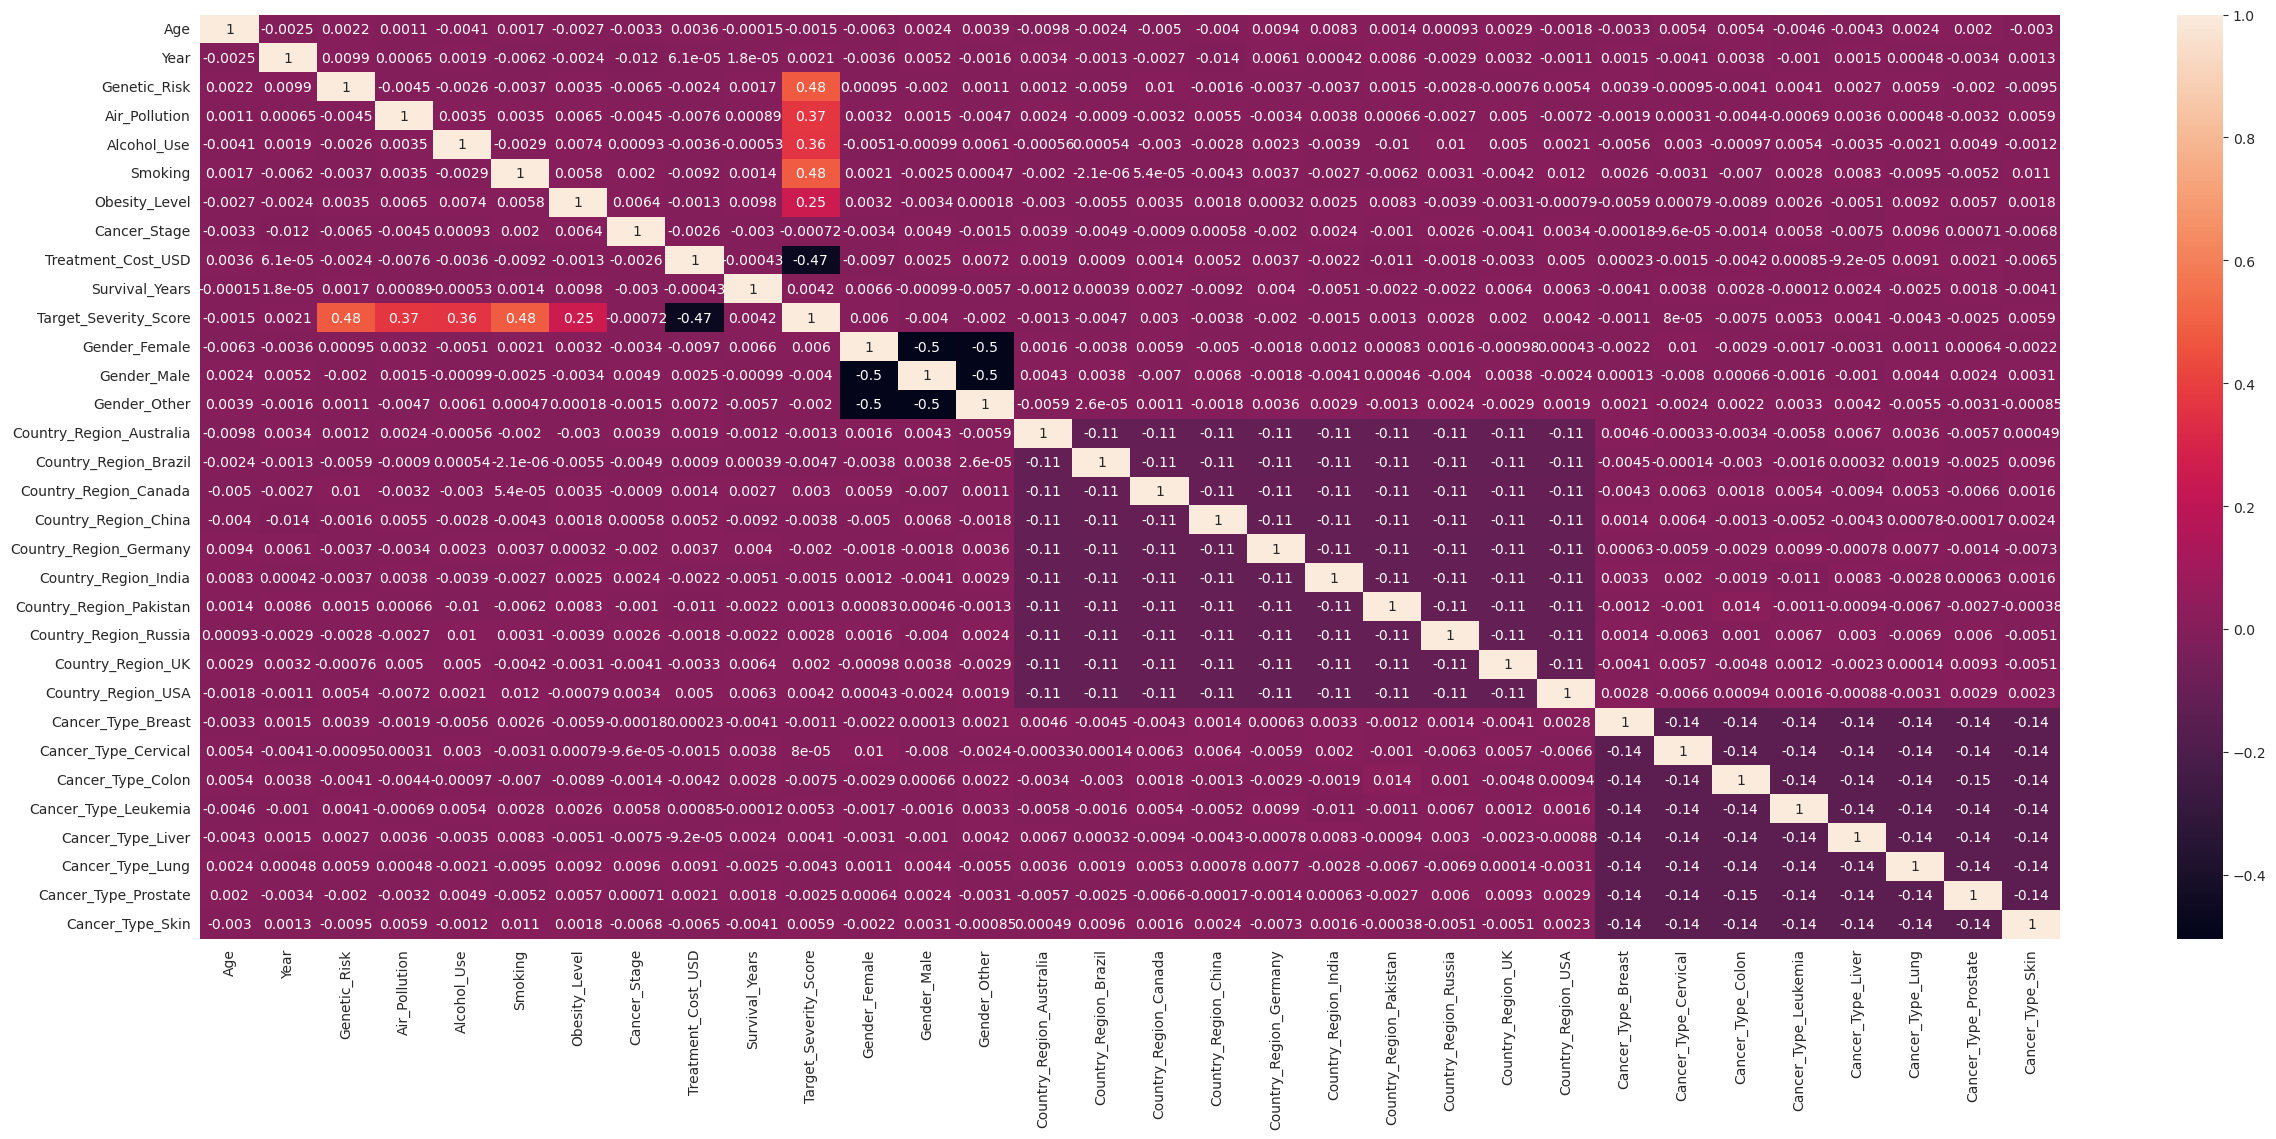

In [14]:
# Numerical feature correlation matrix
fig, axes = plt.subplots(figsize=(30, 12))
sns.heatmap(df_engineered.corr('pearson', numeric_only=True), annot=True, ax=axes)

### Observations from correlation matrix after one-hot encoding
- One-hot representations of features have negative correlational values among categories in that feature. This ensures that one-hot encoding orthogonalizes categories in categorical features.
- There are strong correlations between `Target_Severity_Score`, `Treatment_Cost_USD`, and features representing health risk factors, but not many strong correlations between one-hot encoded categorical features among the other features. 

In [15]:
numericalize_transformer = FunctionTransformer(cancer_stage_map)
numericalize_transformer

FunctionTransformer(func=<function cancer_stage_map at 0x7430848632e0>)

In [16]:
# Set up ColumnTransformer to standardize/normalize specific numerical columns in X
X_standardize_features = ['Age', 'Year']
X_normalize_features = ['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level']
X_numericalize_features = ['Cancer_Stage']
X_categorical_features = ['Gender', 'Cancer_Type', 'Country_Region']
X_drop_features = ['Patient_ID']

X_feature_scaler = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), X_standardize_features),
        ('normalize', MinMaxScaler(), X_normalize_features),
        ('onehot', OneHotEncoder(), X_categorical_features),
        ('numericalize', numericalize_transformer, X_numericalize_features),
        ('drop', 'drop', X_drop_features),
    ],
    remainder='passthrough'
)

X_feature_scaler

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardize', StandardScaler(),
                                 ['Age', 'Year']),
                                ('normalize', MinMaxScaler(),
                                 ['Genetic_Risk', 'Air_Pollution',
                                  'Alcohol_Use', 'Smoking', 'Obesity_Level']),
                                ('onehot', OneHotEncoder(),
                                 ['Gender', 'Cancer_Type', 'Country_Region']),
                                ('numericalize',
                                 FunctionTransformer(func=<function cancer_stage_map at 0x7430848632e0>),
                                 ['Cancer_Stage']),
                                ('drop', 'drop', ['Patient_ID'])])

In [17]:
# Set up ColumnTransformer to standardize/normalize specific numerical columns in y

y_standardize_features = ['Treatment_Cost_USD', 'Survival_Years']
y_normalize_features = ['Target_Severity_Score']

y_feature_scaler = ColumnTransformer(
    transformers=[
        ('standardize', StandardScaler(), y_standardize_features),
        ('normalize', MinMaxScaler(), y_normalize_features),
    ]
)

y_feature_scaler

ColumnTransformer(transformers=[('standardize', StandardScaler(),
                                 ['Treatment_Cost_USD', 'Survival_Years']),
                                ('normalize', MinMaxScaler(),
                                 ['Target_Severity_Score'])])

### Train/validation/test split
Since there are \$m=50000\$ samples, we can preliminarily split the training, validation, and test datasets into a distribution of 80%/10%/10%.
- Training: \$50000 \text{ samples} * 80\\% = 40000 \text{ samples}\$
- Validation and testing: \$50000 \text{ samples} * 10\\% = 5000 \text{ samples each}\$

> Note: in practice, it is important that validation and testing datasets come from the same distribution. If model is tuned using validation dataset, but the validation dataset does not reflect the testing dataset, then the model will predictably perform worse on the testing dataset.

In [18]:
# Dropping irrelevant column(s), rearranging df into X and Y dataframes
output_columns = ['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']

X = df.drop(columns=output_columns)
y = df[output_columns]

In [19]:
# Split df into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Split testing datasets into validation and testing datasets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=99)

# Fitting to X_train, and transforming all input datasets
X_train_transformed = X_feature_scaler.fit_transform(X_train)
X_val_transformed = X_feature_scaler.transform(X_val)
X_test_transformed = X_feature_scaler.transform(X_test)

# Fitting to y_train, and transforming all output datasets
y_train_transformed = y_feature_scaler.fit_transform(y_train)
y_val_transformed = y_feature_scaler.transform(y_val)
y_test_transformed = y_feature_scaler.transform(y_test)

> Note: `X.shape` is \$\(m, n\)\$ where \$m\$ and \$n\$ represent the number of samples and number of features, respectively.

In [20]:
X_train_transformed.shape

(40000, 29)

In [21]:
# Building PyTorch dataset class to use Pandas dataframes
class MultivariateRegressionDataset(Dataset):
    def __init__(self, X, y, device="cpu"):
        self.X = torch.from_numpy(X).float().to(device)
        self.y = torch.from_numpy(y).float().to(device)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Modeling
### Netrics
#### Loss function
Mean squared error (MSE) is a commonly used loss function and performance metric in regression problems. With MSE, outliers are penalized heavier than predictions that land closer to ground truths. MSE for a single output feature can be formulated as:

$$
\text{MSE} = \frac{1}{m} \sum^{m}_{i=1} \\(Y^{\\(i\\)} - \hat{Y^{\\(i\\)}}\\)^{2}
$$

where \$m\$ represents the batch sample size, and \$Y_{i}\$ and \$\hat{Y_{i}}\$ represent the ground truth and predicted value, respectively.

For this case study, the \$\text{MSE}\$ formula will be used as the loss function across all three output features (`Treatment_Cost_USD`, `Survival_Years`, and `Target_Severity_Score`).

#### Performance metric
Because regression outputs are continuous, performance metrics are not as straightforward as correct/incorrect prediction ratios, unlike classification problems where metrics like F1-score and AUROC can be employed.

One effective metric used in regression problems is the coefficient of determination, also known as the \$R^{2}\$ score. \$R^{2}\$ represents how accurately a regression model can predict outputs. \$R^{2}\$ ranges typically from 0 to 1, with models with lower \$R^{2}\$ scores closer to 0 (or even negative) being less likely to predict expected outcomes accurately than models with higher \$R^{2}\$ scores closer to 1. \$R^{2}\$ can be formulated as:

$$
R^{2} = 1 - \frac{SS_{res}}{SS_{tot}} = \frac{\sum_{i}\\(y^{\\(i\\)} - \hat{y^{\\(i\\)}}\\)^{2}}{\sum_{i}\\(y^{\\(i\\)} - \bar{y}\\)^{2}}
$$

where \$SS_{res}\$ and \$SS_{tot}\$ refer to the residual sum of squares and the total sum of squares, respectively. \$R^2\$ is also the square of the Pearson correlation coefficient.

### Model selection
Regression modeling can be done by a number of existing models and algorithms such as support-vector machines (SVM), decision trees, and ensembles methods like random forest. In this project, however, I will be building and training a deep neural network for tooling exploration.

### Model assembly
As a baseline test, an un-tuned deep neural network model can be constructed to gauge initial model performance against the validation set, after which grid search will be used to fine-tune hyperparameters.


In [22]:
# Initial model assembly: 3 hidden layers
# Shape reference:
# X: (m, n)
# Y: (m, 3)
n_input = X_train_transformed.shape[1]
n_output = y_train_transformed.shape[1]

class MultivariateRegressionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_input, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_output),
        )

    def forward(self, X):
        return self.model(X)

MultivariateRegressionNN().to(device)

MultivariateRegressionNN(
  (model): Sequential(
    (0): Linear(in_features=29, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=3, bias=True)
  )
)

In [23]:
# Mini-batch gradient descent (1 function call = 1 epoch)
def train(X, y, model, loss_fn, optimizer, metric, mini_batch_size=None):
    training_dataloader = DataLoader(
        MultivariateRegressionDataset(X, y, device=device),
        batch_size=mini_batch_size or X.shape[0],   # default to batch gradient descent
        shuffle=True,
        drop_last=True,
    )

    mini_batch_losses = []
    model.train()
    metric.reset()
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        # 1. forward prop
        yhat_batch = model(X_batch)

        # 2. calculate loss
        loss = loss_fn(yhat_batch, y_batch)

        # 3. update parameters
        optimizer.zero_grad()   # zero the gradient from previous step
        loss.backward()         # backward prop
        optimizer.step()        # updates parameters

        # 4. record loss and update metric
        mini_batch_losses.append(loss.item())
        metric.update(yhat_batch, y_batch)

    return np.average(mini_batch_losses), metric.compute().cpu()    # average mini_batch losses and metric in epoch

def test(X, y, model, loss_fn, metric, mini_batch_size=None):
    test_dataloader = DataLoader(
        MultivariateRegressionDataset(X, y, device=device),
        batch_size=mini_batch_size or X.shape[0],
        shuffle=False,
        drop_last=False,
    )

    mini_batch_losses = []
    model.eval()
    metric.reset()
    with torch.no_grad():
        for mini_batch_idx, (X_batch, y_batch) in enumerate(test_dataloader):
            yhat_batch = model(X_batch)
            loss = loss_fn(yhat_batch, y_batch)
            mini_batch_losses.append(loss.item())
            metric.update(yhat_batch, y_batch)

    return np.average(mini_batch_losses), metric.compute().cpu()

In [24]:
# Define model
model = MultivariateRegressionNN().to(device)

# Define optimizer. Adam will be used for performance
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss function. `nn.MSELoss()` is capable of handling MSE for multi-feature outputs.
loss_fn = nn.MSELoss(reduction='mean')

# Define metric (R2)
metric = R2Score(device=device)

# Train over 100 epochs
epochs = 100

average_mini_batch_losses = []
epoch_r2_scores = []
for epoch in range(epochs):
    average_mini_batch_loss, epoch_r2_score = train(X_train_transformed, y_train_transformed, model, loss_fn, optimizer, metric, mini_batch_size=64)
    average_mini_batch_losses.append(average_mini_batch_loss)
    epoch_r2_scores.append(epoch_r2_score.item())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch};\tAverage mini-batch loss: {average_mini_batch_loss};\tAverage mini-batch r2: {epoch_r2_score}")

print("\n--- Final results ---")
print(f"Epoch: {epochs};\tAverage mini-batch loss: {average_mini_batch_losses[-1]};\tAverage mini-batch r2: {epoch_r2_scores[-1]}")

Epoch: 0;	Average mini-batch loss: 0.6701298104286194;	Average mini-batch r2: 0.20624491572380066
Epoch: 10;	Average mini-batch loss: 0.6531474737644195;	Average mini-batch r2: 0.26775386929512024
Epoch: 20;	Average mini-batch loss: 0.5766181153774261;	Average mini-batch r2: 0.3435593247413635
Epoch: 30;	Average mini-batch loss: 0.4937710988521576;	Average mini-batch r2: 0.43203020095825195
Epoch: 40;	Average mini-batch loss: 0.4344621894359589;	Average mini-batch r2: 0.4890201985836029


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x743183542ed0>>
Traceback (most recent call last):
  File "/root/miniconda3/envs/torch-gpu/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


KeyboardInterrupt: 

Text(0, 0.5, 'Loss and R2 score')

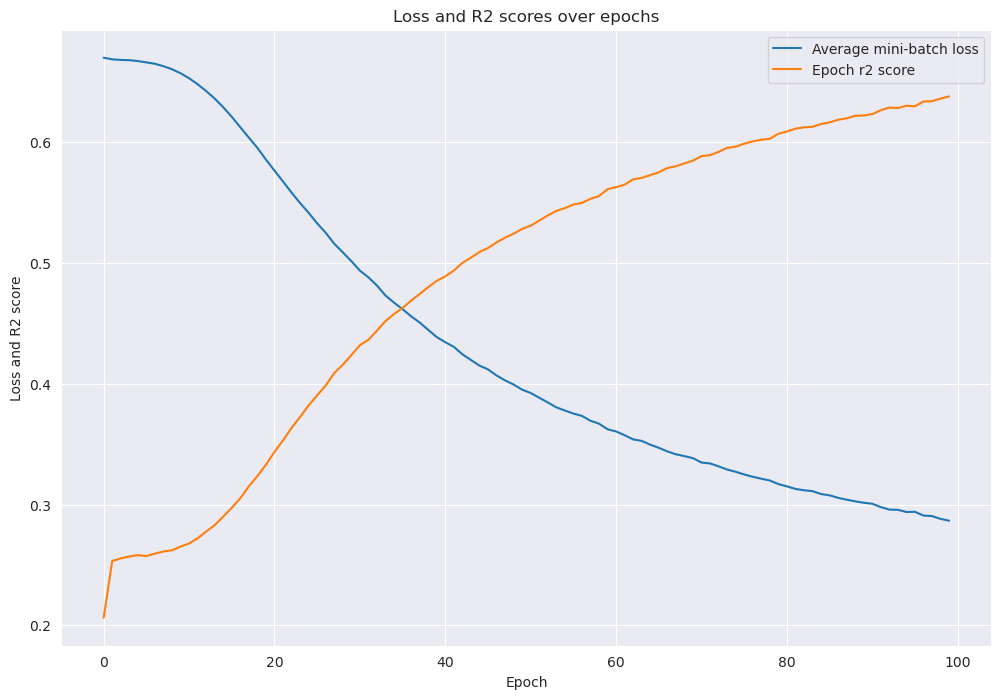

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

sns.lineplot(x=range(epochs), y=average_mini_batch_losses, label="Average mini-batch loss")
sns.lineplot(x=range(epochs), y=epoch_r2_scores, label="Epoch r2 score")
axes.set_title("Loss and R2 scores over epochs")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss and R2 score")

In [26]:
# Find loss and r2 value against validation dataset
val_average_mini_batch_loss, val_epoch_r2_score = test(X_val_transformed, y_val_transformed, model, loss_fn, metric, mini_batch_size=64)
print(f"Validation average loss: {val_average_mini_batch_loss};\tValidation r2 score: {val_epoch_r2_score}")

Validation average loss: 1.093755386298216;	Validation r2 score: -0.2578596770763397


## Initial observations
- Over 100 iterations, the training loss decreased from 0.67 to 0.29, while the \$R^2\$ value increased from 0.20 to 0.63.
- The initial sharp incline in \$R^2\$ score could indicate quick learning, where the model is able to grasp some patterns easily between "low-hanging-fruit" features.
- The model performed notably worse on the validation dataset. This would indicate high variance in the model, where the model is overfitting the training data. This is also observed by the high average mini-batch loss (1.10) on the validation set. \$R^2\$ was around -0.26, supporting the claim that this model may have overfit the training data.
    - It is possible that output feature scaling could affect \$R^2\$ score, so an inverse transformation of feature scaling could be applied to attempt fitting the validation dataset better.

In [27]:
# Define inverse transform of output feature scaling
standardize_scaler, normalize_scaler = y_feature_scaler.named_transformers_.values()

def inverse_transform_output_features(output_batch):
    return np.concat((
        standardize_scaler.inverse_transform(output_batch.detach().cpu()[:, 0:2]),             # Treatment_Cost_USD, Survival_Years
        normalize_scaler.inverse_transform(output_batch.detach().cpu()[:, 2].reshape(-1, 1))   # Target_Severity_Score
    ), axis=1)

example_batch = torch.from_numpy(y_val_transformed[:10]).to(device)
print("Example batch of scaled output features:")
print(example_batch)
print("\nExample batch of unscaled output features:")
print(inverse_transform_output_features(example_batch))

Example batch of scaled output features:
tensor([[ 1.2117, -0.4559,  0.2881],
        [ 1.6280, -1.3229,  0.2191],
        [ 1.5253, -0.4559,  0.3462],
        [ 0.1442,  0.2725,  0.5375],
        [-0.3233,  0.5153,  0.6090],
        [-1.3009, -0.2131,  0.7058],
        [-1.0823, -0.6987,  0.6792],
        [-1.4273, -0.3865,  0.4625],
        [ 1.6676, -0.4212,  0.3245],
        [-0.0339, -1.2189,  0.6913]], device='cuda:0', dtype=torch.float64)

Example batch of unscaled output features:
[[8.552182e+04 3.700000e+00 3.280000e+00]
 [9.690164e+04 1.200000e+00 2.710000e+00]
 [9.409462e+04 3.700000e+00 3.760000e+00]
 [5.633717e+04 5.800000e+00 5.340000e+00]
 [4.355597e+04 6.500000e+00 5.930000e+00]
 [1.682746e+04 4.400000e+00 6.730000e+00]
 [2.280531e+04 3.000000e+00 6.510000e+00]
 [1.337283e+04 3.900000e+00 4.720000e+00]
 [9.798653e+04 3.800000e+00 3.580000e+00]
 [5.146629e+04 1.500000e+00 6.610000e+00]]


In [28]:
# Updating train/test logic to account for rescaling
def train_scaled(X, y, model=model, loss_fn=loss_fn, optimizer=optimizer, metric=metric, mini_batch_size=None):
    training_dataloader = DataLoader(
        MultivariateRegressionDataset(X, y, device=device),
        batch_size=mini_batch_size or X.shape[0],   # default to batch gradient descent
        shuffle=True,
        drop_last=True,
    )

    mini_batch_losses = []
    model.train()
    metric.reset()
    for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
        # 1. forward prop
        yhat_batch = model(X_batch)

        # 2. calculate loss
        loss = loss_fn(yhat_batch, y_batch)

        # 3. update parameters
        optimizer.zero_grad()   # zero the gradient from previous step
        loss.backward()         # backward prop
        optimizer.step()        # updates parameters

        # 4. record loss and update metric
        mini_batch_losses.append(loss.item())
        metric.update(
            torch.from_numpy(inverse_transform_output_features(yhat_batch)).to(device),
            torch.from_numpy(inverse_transform_output_features(y_batch)).to(device)
        )

    return np.average(mini_batch_losses), metric.compute().cpu()    # average mini_batch losses and metric in epoch

def test_scaled(X, y, model=model, loss_fn=loss_fn, metric=metric, mini_batch_size=None):
    test_dataloader = DataLoader(
        MultivariateRegressionDataset(X, y, device=device),
        batch_size=mini_batch_size or X.shape[0],
        shuffle=False,
        drop_last=False,
    )

    mini_batch_losses = []
    model.eval()
    metric.reset()
    with torch.no_grad():
        for mini_batch_idx, (X_batch, y_batch) in enumerate(test_dataloader):
            yhat_batch = model(X_batch)
            loss = loss_fn(yhat_batch, y_batch)
            mini_batch_losses.append(loss.item())
            metric.update(
                torch.from_numpy(inverse_transform_output_features(yhat_batch)).to(device),
                torch.from_numpy(inverse_transform_output_features(y_batch)).to(device)
            )

    return np.average(mini_batch_losses), metric.compute().cpu()

In [29]:
# Define loss function. `nn.MSELoss()` is capable of handling MSE for multi-feature outputs.
loss_fn = nn.MSELoss(reduction='mean')

# Define metric (R2)
metric = R2Score(device=device)

# Define model
model = MultivariateRegressionNN().to(device)

# Define optimizer. Adam will be used for performance
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train over 100 epochs
epochs = 100

average_mini_batch_losses = []
epoch_r2_scores = []
for epoch in range(epochs):
    average_mini_batch_loss, epoch_r2_score = train_scaled(X_train_transformed, y_train_transformed, model, loss_fn, optimizer, mini_batch_size=64)
    average_mini_batch_losses.append(average_mini_batch_loss)
    epoch_r2_scores.append(epoch_r2_score.item())
    if epoch % 10 == 0:
        print(f"Epoch: {epoch};\tAverage mini-batch loss: {average_mini_batch_loss};\tAverage mini-batch r2: {epoch_r2_score}")

print("\n--- Final results ---")
print(f"Epoch: {epochs};\tAverage mini-batch loss: {average_mini_batch_losses[-1]};\tAverage mini-batch r2: {epoch_r2_scores[-1]}")

Epoch: 0;	Average mini-batch loss: 0.6704913012504577;	Average mini-batch r2: 0.20323262305159195
Epoch: 10;	Average mini-batch loss: 0.6535472272872925;	Average mini-batch r2: 0.2658833889775095
Epoch: 20;	Average mini-batch loss: 0.5784513671398163;	Average mini-batch r2: 0.34023501366831743
Epoch: 30;	Average mini-batch loss: 0.49955627980232237;	Average mini-batch r2: 0.41751407984885236
Epoch: 40;	Average mini-batch loss: 0.43982741713523865;	Average mini-batch r2: 0.4776637600309693
Epoch: 50;	Average mini-batch loss: 0.3979802670955658;	Average mini-batch r2: 0.5210607257357407
Epoch: 60;	Average mini-batch loss: 0.36563821821212766;	Average mini-batch r2: 0.5543478027114024
Epoch: 70;	Average mini-batch loss: 0.33888789620399473;	Average mini-batch r2: 0.582104549609797
Epoch: 80;	Average mini-batch loss: 0.3192112510919571;	Average mini-batch r2: 0.6029337196234074
Epoch: 90;	Average mini-batch loss: 0.30398418886661527;	Average mini-batch r2: 0.6180123236945645

--- Final res

Text(0, 0.5, 'Loss and R2 score')

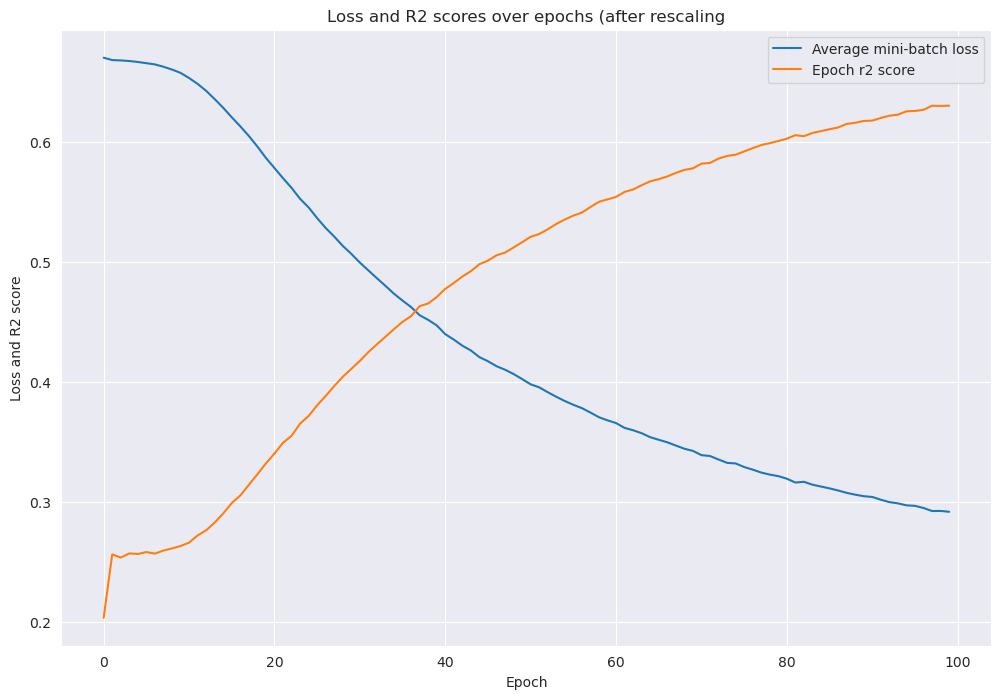

In [30]:
# Find loss and r2 value against validation dataset
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

sns.lineplot(x=range(epochs), y=average_mini_batch_losses, label="Average mini-batch loss")
sns.lineplot(x=range(epochs), y=epoch_r2_scores, label="Epoch r2 score")
axes.set_title("Loss and R2 scores over epochs (after rescaling")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss and R2 score")

In [31]:
# Find loss and r2 value against validation dataset
val_average_mini_batch_loss, val_epoch_r2_score = test_scaled(X_val_transformed, y_val_transformed, model, loss_fn, metric, mini_batch_size=64)
print(f"Validation average loss: {val_average_mini_batch_loss};\tValidation r2 score: {val_epoch_r2_score}")

Validation average loss: 1.1016089667247821;	Validation r2 score: -0.2618453789009505


### Reassessing performance metric (\$R^{2}\$) and understanding overfitting
Unscaling the output vector yielded a comparably bad \$R^2\$ value on the validation set than when the model had used the scaled output features. Without much modification to mini-batch loss, the loss value on the validation set remained much higher than the final training loss.
- MSE decreases over multiple iterations during training, but because the observed loss in the validation set is notably higher, it is likely that the model is overfitting the training data. The model thus is unable to effectively generalize patterns in unseen data (validation and test datasets).
    - A grid-search strategy can be employed to determine an optimum set of hyperparameters that will reduce overfitting.
- \$R^{2}\$ may not be the best performance metric for this regression problem. \$R^{2}\$ is commonly used for regression analysis, but main disadvantages include high sensitivity to outliers and scale, as well as misleading interpretations in multivariate regression problems (Fitzpatrick).
    - For this reason, average mini-batch training loss (MSE) will be used as the primary performance metric for the remainder of this case study.


## Model training enhancements
### Modified feature selection
Previously, all features (with the exception of `Patient_ID`) were considered during feature selection and feature engineering. Upon reviewing the correlation matrix between features, features with the strongest correlations between output variables can be chosen to simplify model training. In this updated model design, the chosen input features will be a subset of the original input features, including only genetic risk factors (`Genetic_Risk`, `Air_Pollution`, `Alcohol_Use`, `Smoking`, and `Obesity_Level`). The output features will remain the same.

In [32]:
# # Selective feature selection
# updated_input_columns = ['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level']
# output_columns = ['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score']
#
# X = df.drop(columns=output_columns)[updated_input_columns]
# y = df[output_columns]

In [58]:
# Split df into training and testing datasets.
# Because we will do k-fold cross validation, we can just split the dataset into training/validation and test datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_feature_scaler = MinMaxScaler()   # standardized input features
# Note: y_feature_scaler is unchanged

# Fitting to X_train, and transforming all input datasets
X_train_transformed = X_feature_scaler.fit_transform(X_train)
X_test_transformed = X_feature_scaler.transform(X_test)

# Fitting to y_train, and transforming all output datasets.
y_train_transformed = y_feature_scaler.fit_transform(y_train)
y_test_transformed = y_feature_scaler.transform(y_test)

# X_train_transformed = X_train.to_numpy()
# X_test_transformed = X_test.to_numpy()
# y_train_transformed = y_train.to_numpy()
# y_test_transformed = y_test.to_numpy()

In [34]:
# n_input = X_train_transformed.shape[1]
# n_output = y_train_transformed.shape[1]
#
# class MultivariateRegressionNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = nn.Sequential(
#             nn.Linear(n_input, 64),
#             nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Linear(32, 16),
#             nn.ReLU(),
#             nn.Linear(16, n_output),
#         )
#
#     def forward(self, X):
#         return self.model(X)
#
# MultivariateRegressionNN().to(device)

In [35]:
# # Mini-batch gradient descent (1 function call = 1 epoch)
# def train(X, y, model, loss_fn, optimizer, metric, mini_batch_size=None):
#     training_dataloader = DataLoader(
#         MultivariateRegressionDataset(X, y, device=device),
#         batch_size=mini_batch_size or X.shape[0],   # default to batch gradient descent
#         shuffle=True,
#         drop_last=True,
#     )
#
#     mini_batch_losses = []
#     model.train()
#     metric.reset()
#     for batch_idx, (X_batch, y_batch) in enumerate(training_dataloader):
#         # 1. forward prop
#         yhat_batch = model(X_batch)
#
#         # 2. calculate loss
#         loss = loss_fn(yhat_batch, y_batch)
#
#         # 3. update parameters
#         optimizer.zero_grad()   # zero the gradient from previous step
#         loss.backward()         # backward prop
#         optimizer.step()        # updates parameters
#
#         # 4. record loss and update metric
#         mini_batch_losses.append(loss.item())
#         metric.update(yhat_batch, y_batch)
#
#     return np.average(mini_batch_losses), metric.compute().cpu()    # average mini_batch losses and metric in epoch
#
# def test(X, y, model, loss_fn, metric, mini_batch_size=None):
#     test_dataloader = DataLoader(
#         MultivariateRegressionDataset(X, y, device=device),
#         batch_size=mini_batch_size or X.shape[0],
#         shuffle=False,
#         drop_last=False,
#     )
#
#     mini_batch_losses = []
#     model.eval()
#     metric.reset()
#     with torch.no_grad():
#         for mini_batch_idx, (X_batch, y_batch) in enumerate(test_dataloader):
#             yhat_batch = model(X_batch)
#             loss = loss_fn(yhat_batch, y_batch)
#             mini_batch_losses.append(loss.item())
#             metric.update(yhat_batch, y_batch)
#
#     return np.average(mini_batch_losses), metric.compute().cpu()

In [36]:
# # Define model
# model = MultivariateRegressionNN().to(device)
#
# # Define optimizer. Adam will be used for performance
# optimizer = optim.Adam(model.parameters(), lr=0.001)
#
# # Define loss function. `nn.MSELoss()` is capable of handling MSE for multi-feature outputs.
# loss_fn = nn.MSELoss(reduction='mean')
#
# # Define metric (R2)
# metric = R2Score(device=device)
#
# # Train over 100 epochs
# epochs = 100
#
# average_mini_batch_losses = []
# epoch_r2_scores = []
# for epoch in range(epochs):
#     average_mini_batch_loss, epoch_r2_score = train(X_train_transformed, y_train_transformed, model, loss_fn, optimizer, metric, mini_batch_size=128)
#     average_mini_batch_losses.append(average_mini_batch_loss)
#     epoch_r2_scores.append(epoch_r2_score.item())
#     if epoch % 10 == 0:
#         print(f"Epoch: {epoch};\tAverage mini-batch loss: {average_mini_batch_loss};\tAverage mini-batch r2: {epoch_r2_score}")
#
# print("\n--- Final results ---")
# print(f"Epoch: {epochs};\tAverage mini-batch loss: {average_mini_batch_losses[-1]};\tAverage mini-batch r2: {epoch_r2_scores[-1]}")

In [37]:
# # Find loss and r2 value against validation dataset
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
#
# sns.lineplot(x=range(epochs), y=average_mini_batch_losses, label="Average mini-batch loss")
# sns.lineplot(x=range(epochs), y=epoch_r2_scores, label="Epoch r2 score")
# axes.set_title("Loss and R2 scores over epochs")
# axes.set_xlabel("Epoch")
# axes.set_ylabel("Loss and R2 score")

In [38]:
# # Find loss and r2 value against validation dataset
# val_average_mini_batch_loss, val_epoch_r2_score = test(X_test_transformed, y_test_transformed, model, loss_fn, metric, mini_batch_size=64)
# print(f"Validation average loss: {val_average_mini_batch_loss};\tValidation r2 score: {val_epoch_r2_score}")

### Hyperparameter fine-tuning
Grid-search is a systematic strategy of testing model performance against permutations of hyperparameter combinations. Some hyperparameters that can be tuned to address overfitting in deep neural networks include:
- Learning rate (\$\alpha\$)
- Regularization type and parameter (\$\lambda\$)
- Optimization algorithm (e.g., SGD, Adam, RMSProp)
- Model architecture (hidden layer count and size)
- Mini-batch size
- Epoch count

In this case study, a subset of hyperparameters will be used for a randomized grid-search to find the set of hyperparameters yielding the best model performance (i.e., least average mini-batch MSE) against the validation set. k-fold cross validation will be used to assess average performance across "k" folds in the training dataset.

In [109]:
# Create model with flexible architecture
class TunedMultivariateRegressionNN(nn.Module):
    def __init__(self, n_input, n_output, hidden_layer_sizes, device="cpu"):
        super().__init__()
        self.model = self._build_model(n_input, n_output, hidden_layer_sizes, device)

    def _build_model(self, n_input, n_output, hidden_layer_sizes, device):
        layers = []
        prev_layer_size = n_input

        for hidden_layers in hidden_layer_sizes:
            layers.extend([nn.Linear(prev_layer_size, hidden_layers), nn.ReLU()])
            prev_layer_size = hidden_layers

        layers.extend([nn.Linear(prev_layer_size, n_output)])
        return nn.Sequential(*layers).to(device)

    def forward(self, X):
        return self.model(X)

In [110]:
# Creating skorch model
model_skorch = NeuralNetRegressor(
    module=TunedMultivariateRegressionNN,
    batch_size=32,
    criterion=nn.MSELoss,
    lr=0.001,
    max_epochs=100,
    module__n_input=X_train_transformed.shape[1],
    module__n_output=y_train_transformed.shape[1],
    module__hidden_layer_sizes=[256, 256, 128],
    module__device=device,
)

In [111]:
# Define hyperparameters
params = {
    'batch_size': [2 ** (n) for n in range(4, 9)],  # 16 to 256
    'max_epochs': [50 * (n) for n in range(1, 7)],   # from 50 to 300
    'optimizer': [optim.Adam, optim.SGD],
    'lr': [0.0005, 0.001, 0.005, 0.01],
    'optimizer__weight_decay': [10 ** (-1 * k) for k in range(1, 5)],   # 0.1 to 0001
    'module__hidden_layer_sizes': [
        [64],
        [128],
        [256],
        [128, 64],
        [256, 128],
        [64, 64, 64],
        [256, 128, 64],
        [32, 32, 16, 16]
    ],
}

In [114]:
# Custom scoring for tensors on GPU. Negative MSE ensures models/hyperparameters with lower MSE to be preferred. Co-generated with Claude
def cuda_negative_mse_loss_criterion(estimator, X, y):
    device = next(estimator.module_.parameters()).device
    X_tensor = X.to(device) if isinstance(X, torch.Tensor) else torch.tensor(X, device=device).float()
    y_tensor = y.to(device) if isinstance(y, torch.Tensor) else torch.tensor(y, device=device).float()

    with torch.no_grad():
        y_pred = estimator.module_(X_tensor)

    mse = torch.mean((y_pred - y_tensor) ** 2).item()
    return -1 * mse  # Negative for maximization

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model_skorch,
    param_distributions=params,
    n_iter=10,   # 10 random hyperparameter permutations. With more time and compute, more hyperparameter permutations can be explored.
    cv=2,       # k=5 fold cross-validation
    scoring=cuda_negative_mse_loss_criterion,
    n_jobs=1,
    random_state=99,
    verbose=0,
)

In [115]:
# Execute random search
random_search.fit(torch.from_numpy(X_train_transformed).float().to(device), torch.from_numpy(y_train_transformed).float().to(device))

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6927        0.6754  0.6114
      2        0.6724        0.6723  0.3519
      3        0.6702        0.6711  0.1625
      4        0.6692        0.6705  0.1596
      5        0.6688        0.6702  0.1585
      6        0.6685        0.6699  0.1640
      7        0.6683        0.6697  0.1623
      8        0.6682        0.6695  0.1608
      9        0.6681        0.6694  0.1575
     10        0.6681        0.6692  0.1662
     11        0.6680        0.6691  0.1596
     12        0.6680        0.6690  0.1598
     13        0.6680        0.6690  0.1980
     14        0.6680        0.6689  0.2321
     15        0.6680        0.6688  0.2636
     16        0.6680        0.6687  0.2018
     17        0.6680        0.6687  0.1850
     18        0.6680        0.6686  0.2298
     19        0.6680        0.6686  0.1573
     20        0.6680        0.6685  0.1732
     21        0.6680        0.6

RandomizedSearchCV(cv=2,
                   estimator=NeuralNetRegressor(_params_to_validate={'module__device', 'module__hidden_layer_sizes', 'module__n_output', 'module__n_input'}, batch_size=32, callbacks=None, compile=False, dataset=<class 'skorch.dataset.Dataset'>, device='cpu', iterator_train=<class 'torch.utils.data.dataloader.DataLoader'>, iterator_valid=<class 'torch.utils...
                                        'max_epochs': [50, 100, 150, 200, 250,
                                                       300],
                                        'module__hidden_layer_sizes': [[64],
                                                                       [128],
                                                                       [256],
                                                                       [128,
                                                                        64],
                                                                       [256,
                                                                        128],
                                                                       [64, 64,
                                                                        64],
                                                                       [256,
                                                                        128,
                                                                        64],
                                                                       [32, 32,
                                                                        16,
                                                                        16]],
                                        'optimizer': [<class 'torch.optim.adam.Adam'>,
                                                      <class 'torch.optim.sgd.SGD'>],
                                        'optimizer__weight_decay': [0.1, 0.01,
                                                                    0.001,
                                                                    0.0001]},
                   random_state=99,
                   scoring=<function cuda_negative_mse_loss_criterion at 0x738ab54f6840>)

In [117]:
# Finding the best hyperparameter combination for the model
best_params = random_search.best_params_
best_score = random_search.best_score_
best_model = random_search.best_estimator_

print(f"Best parameters:", best_params)
print(f"Best score:", best_score)
print(f"Best model:",best_model)

Best parameters: {'optimizer__weight_decay': 0.01, 'optimizer': <class 'torch.optim.adam.Adam'>, 'module__hidden_layer_sizes': [64], 'max_epochs': 150, 'lr': 0.0005, 'batch_size': 128}
Best score: -0.668891191482544
Best model: <class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=TunedMultivariateRegressionNN(
    (model): Sequential(
      (0): Linear(in_features=29, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=3, bias=True)
    )
  ),
)


## References:
___

### Research
Caldiroli, Cristina Liviana, et al. “Resilience as a Mediator of Quality of Life in Cancer Patients in Healthcare Services.” Scientific Reports, vol. 15, no. 1, 12 Mar. 2025, www.nature.com/articles/s41598-025-93008-2, https://doi.org/10.1038/s41598-025-93008-2.

Davis, Mellar, and David Hui. “Quality of Life in Palliative Care.” Expert Review of Quality of Life in Cancer Care, vol. 2, no. 6, 2 Nov. 2017, pp. 293–302, https://doi.org/10.1080/23809000.2017.1400911.

Fitzpatrick, Lynne. “The Limitations of R2 in Correlation Studies.” George Lee Sye, 13 Nov. 2023, georgeleesye.com/the-limitations-of-r%C2%B2-in-correlation-studies/.

Nayak, Malathi G., et al. “Quality of Life among Cancer Patients.” Indian Journal of Palliative Care, vol. 23, no. 4, 2017, p. 445, www.ncbi.nlm.nih.gov/pmc/articles/PMC5661349/, https://doi.org/10.4103/ijpc.ijpc_82_17.

Teoli, Dac, and Abhishek Bhardwaj. “Quality of Life.” PubMed, StatPearls Publishing, 27 Mar. 2023, www.ncbi.nlm.nih.gov/books/NBK536962/.

### Dataset
Zahid Feroze. “Global_cancer_patients_2015_2024.” Kaggle.com, 2015, www.kaggle.com/datasets/zahidmughal2343/global-cancer-patients-2015-2024/data. Accessed 28 Apr. 2025.